In [1]:
# Generic
import typing

# Numerical Computing
import numpy as np
import torch
from jaxtyping import Float, Int, Bool

from muutils.nbutils.configure_notebook import configure_notebook, plotshow
# TransformerLens imports
from transformer_lens import ActivationCache, HookedTransformer

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig

# mechinterp stuff
from maze_transformer.mechinterp.plot_attention import plot_attention_anim
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data



c:\Users\mivan\AppData\Local\pypoetry\Cache\virtualenvs\understanding-search-experiments-1eWz7Qts-py3.11\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=43, dark_mode=False, plot_mode="save", fig_output_fmt="pdf", fig_basepath="figures")
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


Figures will be saved to: 'figures'
set up plots with PLOT_MODE = 'save', FIG_OUTPUT_FMT = 'pdf', FIG_BASEPATH = 'figures'
DEVICE = device(type='cuda')


In [3]:
MODEL: ZanjHookedTransformer; DATASET: MazeDataset
MODEL, DATASET = load_model_with_test_data(
	# model_path="../examples/wandb.jerpkipj.zanj",
	# model_path="../examples/model.hallway-insto.v17.zanj",
	model_path="../models/model.hallway-jvq.final.zanj",
	dataset_cfg_source=MazeDatasetConfig(
		name="hallway",
		grid_n=7,
		n_mazes=200,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
		maze_ctor_kwargs=dict(do_forks=False),
		seed=43,
	),
	n_examples=200,
)

F:\KNC\maze-dataset\maze_dataset\dataset\dataset.py:61: UserWarning:

in GPTDatasetConfig self.name='hallway', self.seed=43 is trying to override GLOBAL_SEED=42 which has already been changed elsewhere from DEFAULT_SEED=42



loaded model with 1.2M params (num_params = 1238076) from:
	path: ../models/model.hallway-jvq.final.zanj
	original model name: 'model.zanj_model_config.name = 'hallway_v3'', changing to 'hallway-jvq.final'
	model tensors on devices: {device(type='cuda', index=0)}
loaded dataset with 200 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g7-n200-a_dfs-h12736', 'sdc_hash': 28873668702348942363820530582087178120863432918308260517317237820927875012736, 'seed': 43, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid_n': 7, 'grid_shape': (7, 7), 'n_mazes': 200, 'maze_ctor_name': 'gen_dfs', 'maze_ctor_kwargs': {'do_forks': False}}


In [4]:
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer
DATASET_TOKENS: list[list[str]] = DATASET.as_tokens(TOKENIZER, join_tokens_individual_maze=False)

# print some info
print(f"loaded {len(DATASET_TOKENS)} mazes")
print(f"first maze:\n{' '.join(DATASET_TOKENS[0])}")
print(f"first maze, colored:\n{color_maze_tokens_AOTP(DATASET_TOKENS[0], fmt='terminal')}")

loaded 200 mazes
first maze:
<ADJLIST_START> (2,0) <--> (1,0) ; (4,0) <--> (4,1) ; (5,2) <--> (4,2) ; (3,2) <--> (3,1) ; (0,0) <--> (0,1) ; (4,1) <--> (5,1) ; (1,2) <--> (1,3) ; (0,1) <--> (0,2) ; (3,3) <--> (3,2) ; (0,3) <--> (0,2) ; (5,3) <--> (4,3) ; (4,3) <--> (4,2) ; (5,4) <--> (4,4) ; (6,4) <--> (6,3) ; (3,0) <--> (3,1) ; (5,3) <--> (6,3) ; (6,1) <--> (6,2) ; (1,1) <--> (1,2) ; (6,4) <--> (5,4) ; (6,2) <--> (5,2) ; (2,0) <--> (3,0) ; (3,4) <--> (4,4) ; (0,3) <--> (1,3) ; (3,4) <--> (3,3) ; (5,1) <--> (6,1) ; (1,0) <--> (1,1) ; <ADJLIST_END> <ORIGIN_START> (0,3) <ORIGIN_END> <TARGET_START> (3,3) <TARGET_END> <PATH_START> (0,3) (1,3) (1,2) (1,1) (1,0) (2,0) (3,0) (3,1) (3,2) (3,3) <PATH_END>
first maze, colored:
<ADJLIST_START> (2,0) <--> (1,0) ; (4,0) <--> (4,1) ; (5,2) <--> (4,2) ; (3,2) <--> (3,1) ; (0,0) <--> (0,1) ; (4,1) <--> (5,1) ; (1,2) <--> (1,3) ; (0,1) <--> (0,2) ; (3,3) <--> (3,2) ; (0,3) <--> (0,2) ; (5,3) <--> (4,3) ; (4,3) <--> (4,2) ; (5,4) <--> (4,4) ; (6,4) <--> 

In [5]:
LOGITS: Float[torch.Tensor, "n_mazes seq_len d_vocab"]
CACHE: ActivationCache
LOGITS, CACHE = MODEL.run_with_cache([' '.join(x) for x in DATASET_TOKENS])

In [6]:
print(f"{LOGITS.shape = }")
cache_shapes: dict[str, tuple[int, ...]] = {k: v.shape for k, v in CACHE.items()}
print(f"{cache_shapes = }")

LOGITS.shape = torch.Size([200, 217, 60])
cache_shapes = {'hook_embed': torch.Size([200, 217, 128]), 'hook_pos_embed': torch.Size([200, 217, 128]), 'blocks.0.hook_resid_pre': torch.Size([200, 217, 128]), 'blocks.0.ln1.hook_scale': torch.Size([200, 217, 1]), 'blocks.0.ln1.hook_normalized': torch.Size([200, 217, 128]), 'blocks.0.attn.hook_q': torch.Size([200, 217, 4, 32]), 'blocks.0.attn.hook_k': torch.Size([200, 217, 4, 32]), 'blocks.0.attn.hook_v': torch.Size([200, 217, 4, 32]), 'blocks.0.attn.hook_attn_scores': torch.Size([200, 4, 217, 217]), 'blocks.0.attn.hook_pattern': torch.Size([200, 4, 217, 217]), 'blocks.0.attn.hook_z': torch.Size([200, 217, 4, 32]), 'blocks.0.hook_attn_out': torch.Size([200, 217, 128]), 'blocks.0.hook_resid_mid': torch.Size([200, 217, 128]), 'blocks.0.ln2.hook_scale': torch.Size([200, 217, 1]), 'blocks.0.ln2.hook_normalized': torch.Size([200, 217, 128]), 'blocks.0.mlp.hook_pre': torch.Size([200, 217, 512]), 'blocks.0.mlp.hook_post': torch.Size([200, 217, 512])

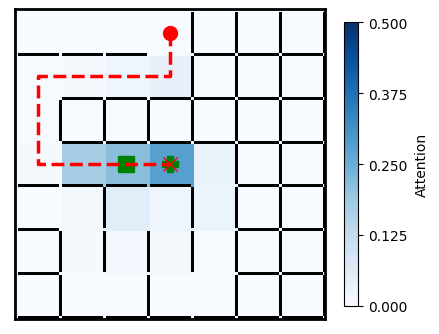

In [32]:
assert MODEL.config.tokenizer.padding_side == "left"
assert MODEL.config.tokenizer.truncation_side == "left"

n_mazes_to_animate: int = 1

for i in range(n_mazes_to_animate):
	plot_attention_anim(
		cache=CACHE,
		maze_id=i,
		mazes=DATASET.mazes,
		mazes_tokens=DATASET_TOKENS,
		end_offset=-2,
		head_id=(5, 3),
		fps=1.5,
		figsize=(5, 5),
	)